## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.



Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

## 1 Подготовка

In [2]:
pth1 = "D:/YP/ML/taxi/taxi.csv"
pth2 = "/datasets/taxi.csv"

if os.path.exists(pth1):
    taxi = pd.read_csv(pth1, index_col=0, parse_dates=True)
elif os.path.exists(pth2):
    taxi = pd.read_csv(pth2, index_col=0, parse_dates=True)
else:
    print('Something is wrong')

In [3]:
taxi.head(8)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5


In [4]:
taxi.tail(8)

,num_orders
datetime,
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
taxi.index.is_monotonic

True

### Ресемплируем данные по 1 часу

In [7]:
taxi = taxi.resample('1H').sum()

In [8]:
taxi.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


### Вывод:

1. Всего данных `26496` с `2018-03-01` по `2018-08-31`.
2. Пропусков нет.
3. Тип данных в столбце `num_orders` изменять не надо.
4. Данные монотонные.
5. Провели ресемплипрвание данных по `1 часу`.

## 2 Анализ

### Просмотр ресемплированных данных

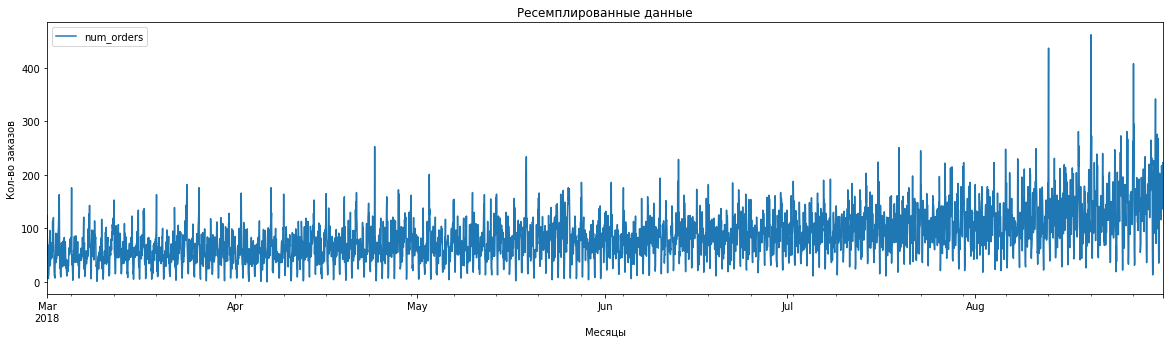

In [9]:
taxi.plot(figsize=(20,5))
plt.title('Ресемплированные данные')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

### Проанализируем последний доступный месяц:

График за август:

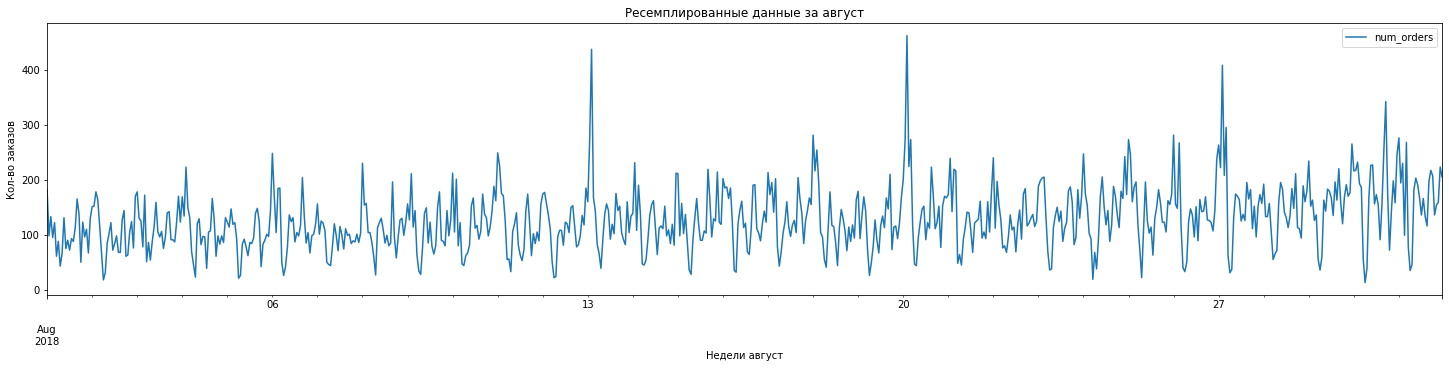

In [10]:
taxi_august = taxi['2018-08-01':]
taxi_august.plot(figsize= (25,5) ) 
plt.title('Ресемплированные данные за август')
plt.xlabel('Недели август')
plt.ylabel('Кол-во заказов')
plt.show()

График за последнюю неделю августа:

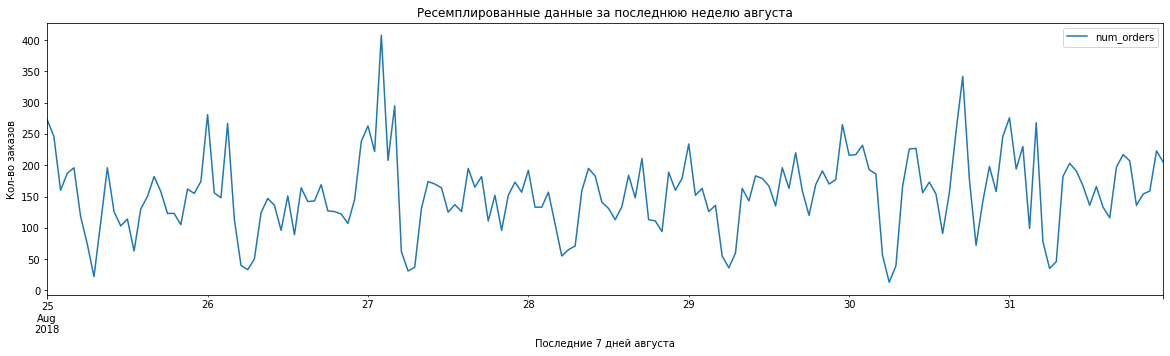

In [11]:
#вывожу график за последнюю неделю августа:
taxi_august_week = taxi['2018-08-25':]
taxi_august_week.plot(figsize=(20,5))
plt.title('Ресемплированные данные за последнюю неделю августа')
plt.xlabel('Последние 7 дней августа')
plt.ylabel('Кол-во заказов')
plt.show()

График за последни день августа:

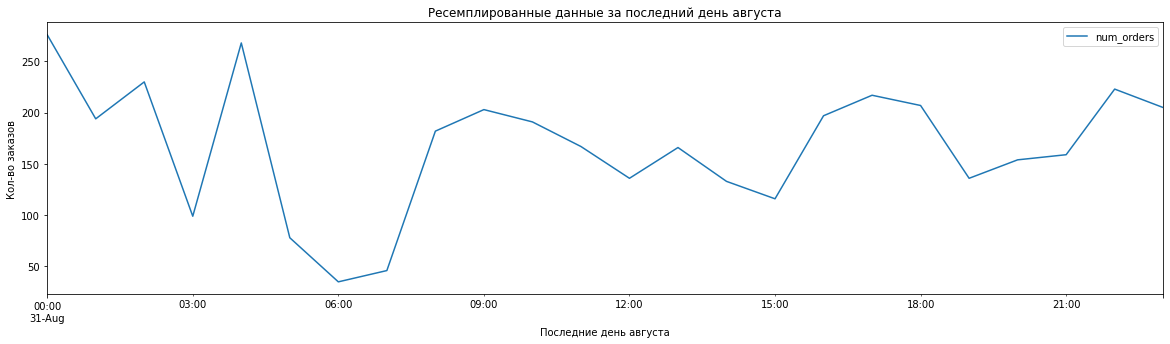

In [12]:
taxi_august_last_day = taxi['2018-08-31':]
taxi_august_last_day.plot(figsize=(20,5))
plt.title('Ресемплированные данные за последний день августа')
plt.xlabel('Последние день августа')
plt.ylabel('Кол-во заказов')
plt.show()

### Декомпозиция:

In [13]:
decomposed = seasonal_decompose(taxi.num_orders)
decomposed_august = seasonal_decompose(taxi_august.num_orders)
decomposed_august_week= seasonal_decompose(taxi_august_week.num_orders)

### Посмотри тренды:

Тренд за весь период:

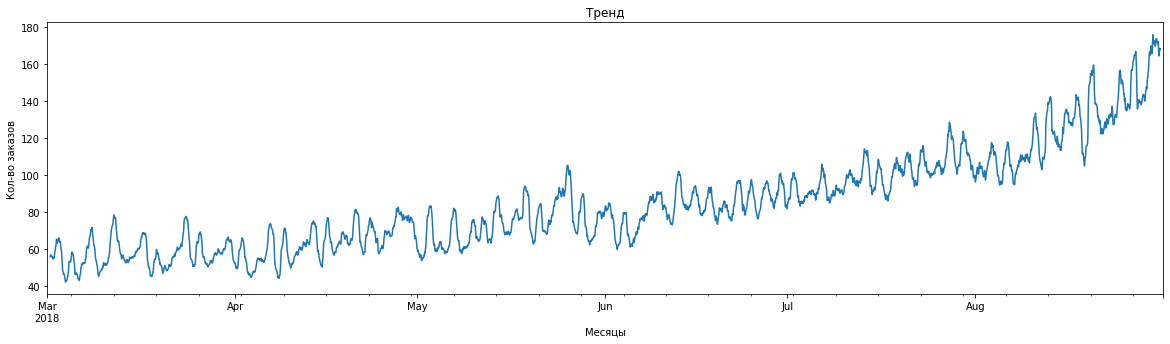

In [14]:
decomposed.trend.plot(figsize=(20,5))
plt.title('Тренд')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Тренд на август:

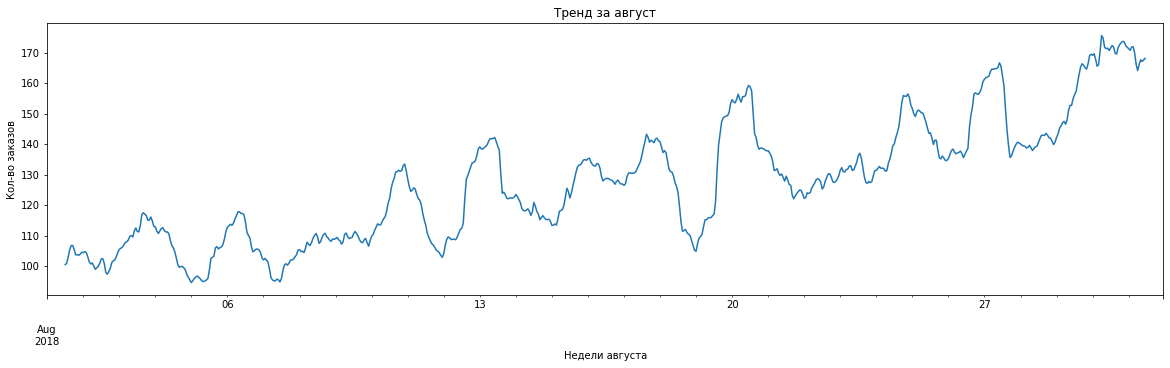

In [15]:
decomposed_august.trend.plot(figsize=(20,5))
plt.title('Тренд за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

Тренд на неделю:

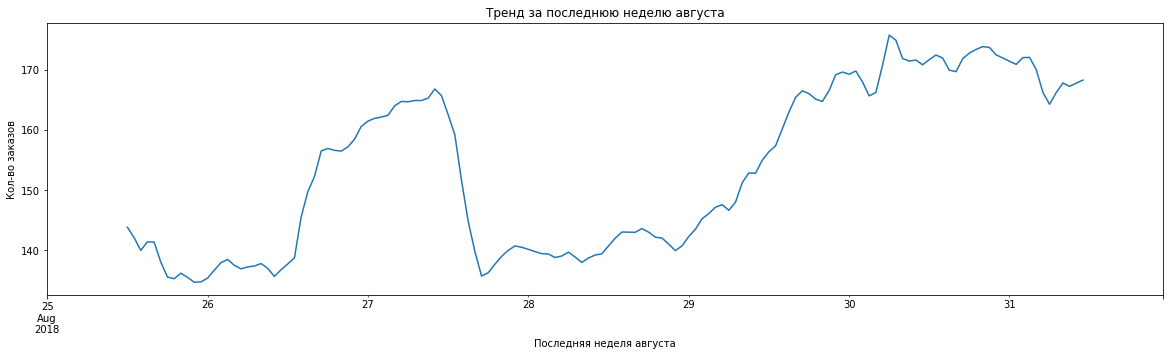

In [16]:
decomposed_august_week.trend.plot(figsize=(20,5))
plt.title('Тренд за последнюю неделю августа')
plt.xlabel('Последняя неделя августа')
plt.ylabel('Кол-во заказов')
plt.show()

### Сезонность: 

Сезонность за весь период:

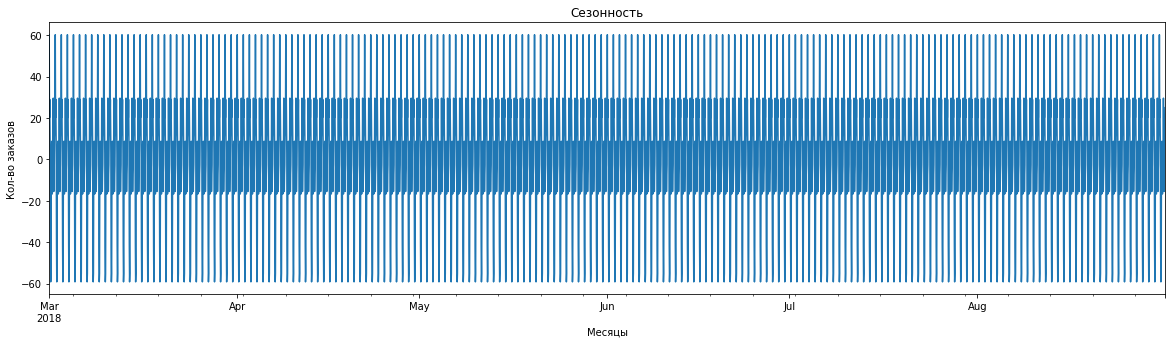

In [17]:
decomposed.seasonal.plot(figsize=(20,5))
plt.title('Сезонность')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Сезонность за август:

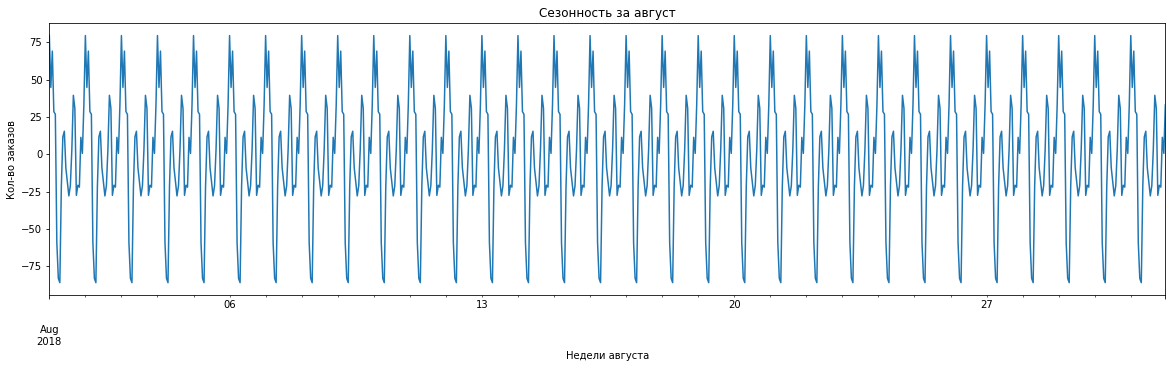

In [18]:
decomposed_august.seasonal.plot(figsize=(20,5))
plt.title('Сезонность за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

Сезонность за неделю:

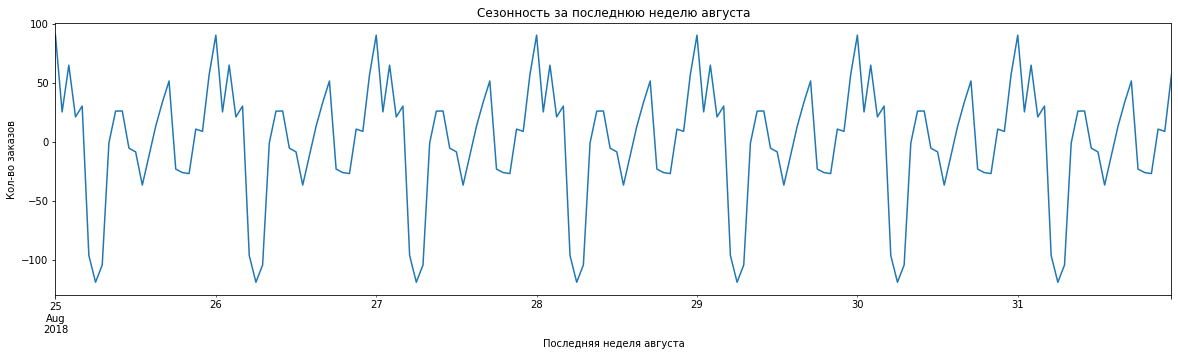

In [19]:
decomposed_august_week.seasonal.plot(figsize=(20,5))
plt.title('Сезонность за последнюю неделю августа')
plt.xlabel('Последняя неделя августа')
plt.ylabel('Кол-во заказов')
plt.show()

### Остатки:

Остатки за весь период:

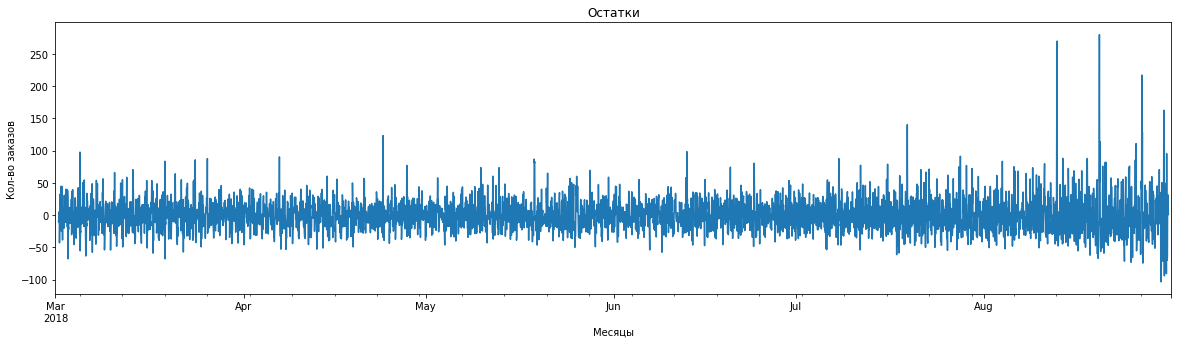

In [20]:
decomposed.resid.plot(figsize=(20,5))
plt.title('Остатки')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Остатки за август:

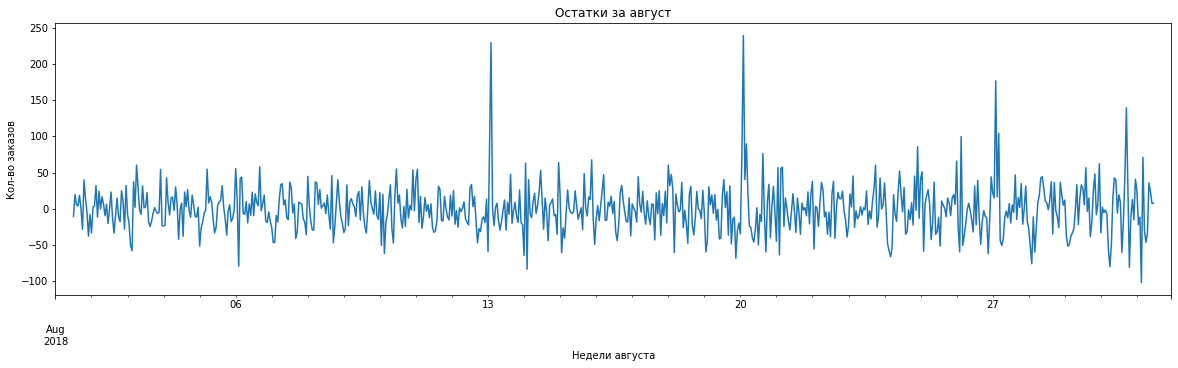

In [21]:
decomposed_august.resid.plot(figsize=(20,5))
plt.title('Остатки за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

Остатки за неделю:

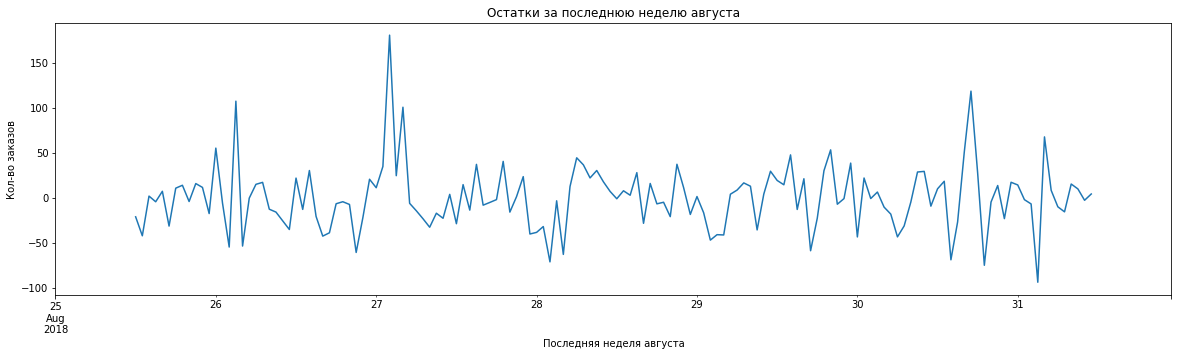

In [22]:
decomposed_august_week.resid.plot(figsize=(20,5))
plt.title('Остатки за последнюю неделю августа')
plt.xlabel('Последняя неделя августа')
plt.ylabel('Кол-во заказов')
plt.show()

### Вывод:

* На графике ресемплированных по 1 часу данных видно, что кол-во заказов начинает возрастать, при этом в августе всплески заказов по понедельникам;
* Сезонность ежедневная :падение заказов рано утром, а рост вечером;
* Тренд идет на явное возрастание;
* Дни по количеству заказов отличаются друг от друга.

## 3 Обучение

### Функция признаков:

In [23]:
def make_features(taxi, max_lag, rolling_mean_size):
    taxi['day'] = taxi.index.day
    taxi['dayofweek'] = taxi.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(taxi, 500, 300)
taxi.shape

(4416, 504)

In [24]:
taxi.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Разьитие на выборки:

In [25]:
train_val, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_val, shuffle=False, test_size=0.25)

train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']

valid_features = valid.drop('num_orders', axis =1)
valid_target = valid['num_orders']

test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

tscv = TimeSeriesSplit(n_splits=3)

In [26]:
print(train.shape, valid.shape, test.shape)

(2980, 504) (994, 504) (442, 504)


### LightGBM:

In [27]:
%%time

parameters_LGBM = {'max_depth':[14, 24, 31], 'learning_rate':[0.35], 'n_estimators': [20,30,50], 'num_leaves':[21, 31, 41]}

model_LGBM = LGBMRegressor(random_state=5678)
grid_LGBM = GridSearchCV(estimator=model_LGBM, param_grid=parameters_LGBM, cv=tscv, scoring="neg_root_mean_squared_error")

grid_LGBM.fit(train_features, train_target)

print('Best parameters is:', grid_LGBM.best_params_)
print('Best score is:', grid_LGBM.best_score_)

Best parameters is: {'learning_rate': 0.35, 'max_depth': 14, 'n_estimators': 20, 'num_leaves': 31}
Best score is: -22.490357646785544
CPU times: total: 2min 40s
Wall time: 58.3 s


In [28]:
%%time
lgbm = LGBMRegressor(num_leaves= 31, learning_rate=0.35, max_depth=14, n_estimators=20)
lgbm.fit(train_features, train_target)
prediction_lgbm = lgbm.predict(valid_features)
rmse_lgbm = mean_squared_error(valid_target, prediction_lgbm)**0.5
rmse_lgbm

CPU times: total: 2.09 s
Wall time: 638 ms


27.91470940211265

### CatBoost:

In [29]:
parameters_catboost = {'learning_rate':[.1, .3], 'n_estimators': [10,20,30]}
model_catboost = CatBoostRegressor(random_state=5678)
grid_catboost = GridSearchCV(estimator=model_catboost, param_grid=parameters_catboost, cv=tscv, scoring="neg_root_mean_squared_error")
grid_catboost.fit(train_features, train_target)
print('Best parameters is:', grid_catboost.best_params_)
print('Best score is:', grid_catboost.best_score_)

0:	learn: 28.3111325	total: 181ms	remaining: 1.63s
1:	learn: 27.3127786	total: 225ms	remaining: 901ms
2:	learn: 26.4353952	total: 271ms	remaining: 633ms
3:	learn: 25.4342945	total: 373ms	remaining: 559ms
4:	learn: 24.6597975	total: 523ms	remaining: 523ms
5:	learn: 24.0653810	total: 600ms	remaining: 400ms
6:	learn: 23.4176572	total: 675ms	remaining: 289ms
7:	learn: 22.9170618	total: 746ms	remaining: 186ms
8:	learn: 22.3521883	total: 819ms	remaining: 91ms
9:	learn: 21.9770009	total: 867ms	remaining: 0us
0:	learn: 29.4252141	total: 62.6ms	remaining: 563ms
1:	learn: 28.2286469	total: 113ms	remaining: 451ms
2:	learn: 27.1593621	total: 164ms	remaining: 382ms
3:	learn: 26.1588265	total: 212ms	remaining: 318ms
4:	learn: 25.3217032	total: 261ms	remaining: 261ms
5:	learn: 24.4451158	total: 320ms	remaining: 213ms
6:	learn: 23.7022296	total: 371ms	remaining: 159ms
7:	learn: 23.1231551	total: 432ms	remaining: 108ms
8:	learn: 22.4715257	total: 506ms	remaining: 56.2ms
9:	learn: 21.9553545	total: 568m

In [30]:
%%time
model_cat = CatBoostRegressor(n_estimators = 30, learning_rate = 0.3, loss_function = 'MAE', eval_metric = 'RMSE')
model_cat.fit(train_features, train_target)
predicted_cat = model_cat.predict(valid_features)
rmse_cat = (mean_squared_error(valid_target, predicted_cat))**0.5
rmse_cat

0:	learn: 29.8076838	total: 71.1ms	remaining: 2.06s
1:	learn: 27.2126336	total: 131ms	remaining: 1.83s
2:	learn: 24.9548680	total: 198ms	remaining: 1.78s
3:	learn: 23.4637456	total: 258ms	remaining: 1.68s
4:	learn: 22.4600807	total: 323ms	remaining: 1.61s
5:	learn: 21.9152317	total: 433ms	remaining: 1.73s
6:	learn: 21.0934076	total: 565ms	remaining: 1.86s
7:	learn: 20.6731482	total: 629ms	remaining: 1.73s
8:	learn: 20.1848722	total: 691ms	remaining: 1.61s
9:	learn: 20.0554904	total: 752ms	remaining: 1.5s
10:	learn: 19.9429803	total: 823ms	remaining: 1.42s
11:	learn: 19.7485229	total: 887ms	remaining: 1.33s
12:	learn: 19.4644844	total: 953ms	remaining: 1.25s
13:	learn: 19.1906201	total: 1.02s	remaining: 1.17s
14:	learn: 19.0470316	total: 1.08s	remaining: 1.08s
15:	learn: 18.9500745	total: 1.15s	remaining: 1s
16:	learn: 18.7777030	total: 1.21s	remaining: 929ms
17:	learn: 18.6628577	total: 1.27s	remaining: 849ms
18:	learn: 18.4960638	total: 1.33s	remaining: 773ms
19:	learn: 18.4048196	tot

29.341777629797615

### Вывод:

Самое лучший показатель RMSE показала модель LightGBM. Поэтому далее протестируем ее.

## 4 Тестирование

In [31]:
pred_lgbm_test = lgbm.predict(test_features)
rmse_light_gbm_test = mean_squared_error(test_target, pred_lgbm_test)**0.5
rmse_light_gbm_test

43.61358656537285

Посмотрим на график:

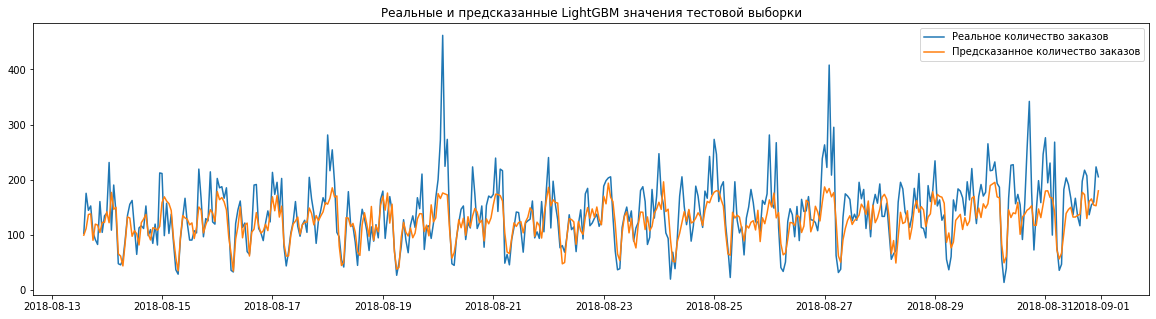

In [32]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(test_target.index, test_target, label='Реальное количество заказов')
ax.plot(test_target.index, pred_lgbm_test, label='Предсказанное количество заказов')
plt.title('Реальные и предсказанные LightGBM значения тестовой выборки')
plt.legend()
plt.show()

## Вывод:

В ходе проекта были изучены способы предсказания временных рядов.

Самое лучшее RMSE на валидационной выборке показала модель LightGBM с GridSearchCV. Ее RMSE равен 27.92. Провери ее на тестовой выборке ее RMSE стал равен 43.61358656537285, что подходит требованиям заказчика. 